# The indirect simple shooting method

* Author: Olivier Cots
* Date: March 2021

------

**_Abstract_**

We present in this notebook the **indirect simple shooting** method based on the [Pontryagin Maximum Principle (PMP)](https://en.wikipedia.org/wiki/Pontryagin%27s_maximum_principle) to solve a smooth optimal control problem. By smooth, we mean that the maximization condition of the PMP gives a control law in feedback form (i.e. with respect to the state and the costate) at least [continuously differentiable](https://en.wikipedia.org/wiki/Smoothness#Differentiability_classes).

We use the [nutopy](https://ct.gitlabpages.inria.fr/nutopy/) package to solve the optimal control problem by simple shooting. You can find another smooth example with more details about the use of nutopy at this [page](https://ct.gitlabpages.inria.fr/gallery/smooth_case/smooth_case.html): note that in this example, the nutopy package is interoperated with the [bocop](https://ct.gitlabpages.inria.fr/bocop3/) software, implementing a direct collocation method.

**_Goal_**

The goal of this presentation is that at the end, you will be able to implement an indirect simple shooting method with nutopy package on an academic optimal control problem for which the optimal control (that is the solution of the problem) is smooth. We assume you have some basic knowledge on optimal control theory.

**_Contents_**

* I) Statement of the optimal control problem and necessary conditions of optimality
    * a) Definition of the optimal control problem
    * b) Application of the Pontryagin Maximum Principle
    * c) The hidden true Hamiltonian
* II) Examples and boundary value problems
    * a) Simple 1D example
    * b) An energy min navigation problem
* III) Indirect simple shooting
    * a) The boundary value problem
    * b) The shooting equation  
    * c) The indirect simple shooting method
* IV) Numerical resolution of the shooting equations with the nutopy package
    * a) Simple 1D example
    * b) Calculus of variations
    * c) An energy min navigation problem - exercice
    
[thumbnail](./simple_shooting.png)

## I) Statement of the optimal control problem and necessary conditions of optimality

### a) Definition of the optimal control problem

We consider the following smooth (all the data are at least $C^1$) *Optimal Control Problem* (OCP) in Lagrange form, with fixed initial condition and final time:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} L(x(t),u(t)) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) =  f(x(t),u(t)), \quad  u(t) \in U, \quad t \in [0, t_f] \text{ a.e.}, \\[1.0em]
        x(0) = x_0 , \quad c(x(t_f)) = 0_{\mathrm{R}^k},
    \end{array}
    \right. 
$$

with $U \subset \mathrm{R}^m$ an arbitrary control set and with $c$ a smooth application such that its Jacobian $c'(x)$ (or $J_c(x)$) is of full rank for any $x$ satisfying the constraint $c(x)=0$. The solution $u$ belongs to the *set of control laws* $L^\infty([0, t_f], \mathrm{R}^m)$.

### b) Application of the Pontryagin Maximum Principle

Let us denote by
$$
    H(x,p,u) := p \, f(x,u) + p^0\, L(x,u),
$$

the *pseudo-Hamiltonian* (that is the non-maximized Hamiltonian) associated to the optimal control problem.

 
According to the Pontryagin Maximum Principle (PMP), if $u$ is solution of the problem (with $x$ the *associated trajectory*), then there exists a *covector* $p$ (which is [absolutely continuous](https://en.wikipedia.org/wiki/Absolute_continuity)), a scalar $p^0 \in \{-1, 0\}$, a *Lagrange multiplier* $\lambda$, such that: 

1. $(p, p^0) \ne (0,0)$,

2. $\displaystyle \dot{x}(t) = \nabla_p H(x(t),p(t),u(t))$, $\displaystyle \dot{p}(t) = -\nabla_x H(x(t),p(t),u(t))$, a.e on $[0, t_f]$,

3. $\displaystyle  H(x(t),p(t),u(t)) = \max_{w \in U} H(x(t), p(t), w)$ a.e on $[0, t_f]$ (maximization condition),

4. $\displaystyle p(t_f) = J_c^T(x(t_f)) \lambda = \sum_{i=1}^k \lambda_i \nabla c_i(x(t_f))$ (transversality condition).

<div class="alert alert-info">

**_Assumptions_**

We assume the following:

* $U = \mathrm{R}^m$,
* $\forall (x,p) \in \mathrm{R}^n \times \mathrm{R}^n$, $u \mapsto H(x,p,u)$ has a unique
    maximum denoted $\varphi(x,p)$ (or $u[x,p]$ to recall the fact that it is the control
    law in feedback form),
* $\varphi$ is smooth, that is at least $C^1$.    
    
</div>

Under these assumptions, the maximization condition (3) is equivalent to the first order necessary condition of optimality and we have:

$$
    \forall (x,p), \quad \nabla_u H(x,p, \varphi(x,p)) = 0.
$$

<!-- <video width=600 src="http://cots.perso.enseeiht.fr/indirect_simple_shooting/video2_PMP.mov" controls>video2_PMP.mov</video>-->




### c) The hidden true Hamiltonian

Let us define the Hamiltonian 
$$
h(z) := H(z, \varphi(z)), \quad z=(x,p).
$$

This is a true Hamiltonian given by the maximization of the pseudo-Hamiltonian $H(z,u)$. By the chain rule, we have:

$$
    h'(z) = \frac{\partial H}{\partial z}(z, \varphi(z)) + \frac{\partial H}{\partial u}(z, \varphi(z)) \cdot \varphi'(z) = \frac{\partial H}{\partial z}(z, \varphi(z)),
$$

since $\frac{\partial H}{\partial u}(z, \varphi(z))=0$. This leads to the remarkable fact that under our assumptions, equations (2) and (3) are equivalent to the Hamiltonian differential equation

$$
    \dot{z}(t) = \vec{h}(z(t)),
$$

where $\vec{h}(z) := (\nabla_p h(z), -\nabla_x h(z))$ is the **symplectic gradient** or **Hamiltonian system** associated to $h$.

<!--<video width=600 src="http://cots.perso.enseeiht.fr/indirect_simple_shooting/video3_HAM.mov" controls>video3_HAM.mov</video>-->



## II) Examples and boundary value problems

### a) Simple 1D example

**_Remark:_** The interest of this example is to present the methodology to solve the conditions given by the Pontryagin maximum principle.

#### Step 1: Definition of the optimal control problem

We consider the optimal control problem:
$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{t_f} u^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) =  \displaystyle -x(t)+u(t), \quad  u(t) \in \mathrm{R}, \quad t \in [0, t_f] \text{ a.e.}, \\[1.0em]
        x(0) = x_0 , \quad x(t_f) = x_f,
    \end{array}
    \right. 
$$

with $t_f := 1$, $x_0 := -1$, $x_f := 0$ and $\forall\, t \in[0, t_f]$, $x(t) \in \mathrm{R}$.

#### Step 2: Application of the Pontryagin maximum principle

The pseudo-Hamiltonian reads

$$
    H(x,p,u) := p \, (-x+u) + p^0\, \frac{1}{2} u^2.
$$

The PMP gives

$$
        \left\{ 
            \begin{array}{rcl}
                \dot{x}(t)  &=& \phantom{-}\nabla_p H[t] = -x(t)+u(t),   \\[0.5em]
                \dot{p}(t)  &=& -\nabla_x H[t] = p(t),         \\[0.5em]
                0           &=& \phantom{-}\nabla_u H[t] = p(t)+p^0 u(t),
            \end{array}
        \right.
$$

where $[t] := (x(t),p(t),u(t))$. If $p^0 = 0$, then $p = 0$ by the third equation and so $(p, p^0) = (0,0)$ which is not. Hence, any *extremal* $(x, p, p^0, u)$ given by the PMP is said to be *normal*, that is $p^0 = -1$ (an extremal is said *abnormal* when $p^0=0$). 

**_Remark:_** We do not consider the transversality condition when the target $x_f$ is fixed. We can retrieve simply the Lagrange multiplier by the relation $p(t_f)=\lambda$.

**_Remark:_** The maximization condition,

$$
H[t] = \max_{w \in \mathrm{R}} H(x(t), p(t), w),
$$

is equivalent here to the condition 
$\nabla_u H[t] = 0$ by concavity.

Solving $\nabla_u H[t] = 0$, the control satisfies $u(t) = u[x(t), p(t)] := p(t)$ where we have introduced the smooth function on $\mathrm{R} \times \mathrm{R}$:

$$
u[x,p] = p.
$$

**_Remark:_** Plugging the control law in feedback form into the pseudo-Hamiltonian gives the (maximized) Hamiltonian:

$$
    h(z) = H(z, u[z]) = -px + \frac{1}{2} p^2, \quad z = (x, p).
$$

#### Step 3: Transcription to a boundary value problem

Now we have the control in feedback form, we introduce the following smooth *Two-Points Boundary Value Problem* (TPBVP or BVP for short):

$$
        \left\{ 
            \begin{array}{rcl}
                \dot{x}(t)  &=& -x(t)+u[x(t),p(t)] = -x(t) + p(t),   \\[0.5em]
                \dot{p}(t)  &=& p(t),         \\[0.5em]
                x(0) &=& x_0, \quad x(t_f) = x_f.
            \end{array}
        \right. 
$$

The unknown of this BVP is the initial covector $p(0)$. Indeed, fixing $p_0:=p(0)$, then according to the [Cauchy-Lipschitz theorem](https://en.wikipedia.org/wiki/Picard–Lindelöf_theorem), there exists a unique maximal solution denoted 

$$
z(\cdot, x_0, p_0) := (x(\cdot, x_0, p_0), p(\cdot, x_0, p_0))
$$

satisfying the dynamics $\dot{z}(t) = (-x(t)+p(t), p(t))$ together with the initial condition $z(0) = (x_0, p_0)$. 

<div class="alert alert-warning">

**_Goal_**
    
The goal is thus to find the right initial covector $p_0$ such that $x(t_f, x_0, p_0) = x_f$.
    
</div>

#### Step 4: Solving the shooting equation

From $\dot{p}(t) = p(t)$, we get
$$
p(t, x_0, p_0) = e^t p_0,
$$
which leads to
$$
x(t, x_0, p_0) = p_0 \sinh(t) + x_0 e^{-t}.
$$
Solving $x(t_f, x_0, p_0) = x_f$, we obtain
$$
 p^*_0 = \frac{x_f - x_0 e^{-t_f}}{\sinh(t_f)} = \frac{2}{e^{2}-1} \approx 0.313.
$$

**_Remark:_** To compute $p^*_0$, we have solved the linear *shooting equation* 

$$
    S(p_0) := \pi_x( z(t_f, x_0, p_0) ) - x_f = p_0 \sinh(t_f) + x_0 e^{-t_f} - x_f,
$$

with $\pi_x(x,p) := x$. Solving $S(p_0) = 0$ is what we call the *indirect simple shooting method*.

<div class="alert alert-info">

**_Summary_**
    
Note that thanks to the PMP, we have replaced the research of u (which is a function of time) by the research of an element of $\mathrm{R}$: the covector $p_0$. The prize of such a drastic reduction is to work in the *cotangent space*, that is the trajectory $x$ is lifted in a bigger space and adjoined with a covector $p$: this makes the simple shooting method to be qualified of *indirect*. It is important to note that in the indirect methods we work with $z=(x,p)$ and not only with the trajectory $x$.

</div>

<!--<video width=600 src="http://cots.perso.enseeiht.fr/indirect_simple_shooting/video4_EX1D.mov" controls>video4_EX1D.mov</video>-->


### b) An energy min navigation problem 

**_Remark:_** The interest of this example is to present a case where we have some transversality conditions.

We consider the optimal control problem:
$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{t_f} u_1^2(t) + u_2^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) =  \displaystyle (1, 0) + u(t), \quad  u(t) \in \mathrm{R}^2, \quad t \in [0, t_f] \text{ a.e.}, \\[1.0em]
        x(0) = (0, 0) , \quad x_2(t_f) = 1.
    \end{array}
    \right. 
$$

The pseudo-Hamiltonian reads

$$
    H(x,p,u) := p_1 + (p | u) - \frac{1}{2} (u_1^2+u_2^2), \quad p^0 = -1.
$$

The PMP gives:

$$
\dot{x} = (1,0) + u, \quad \dot{p} = 0, \quad u = p, \quad p(t_f) = (0, \lambda),
$$

and so we have to solve the BVP:

$$
        \left\{ 
            \begin{array}{rcl}
                \dot{x}(t)  &=& (1, 0) + p(t),   \\[0.5em]
                \dot{p}(t)  &=& 0,         \\[0.5em]
                x(0) &=& (0,0), \quad x_2(t_f) = 1, \quad p(t_f) = (0, \lambda).
            \end{array}
        \right. 
$$

Computing we get,

$$
    u(t) = p(t) = (0, \frac{1}{t_f}), \quad \lambda = \frac{1}{t_f}, \quad x(t) = (t, \frac{t}{t_f}).
$$

<!--<video width=600 src="http://cots.perso.enseeiht.fr/indirect_simple_shooting/video6_EXNAV.mov" controls>video6_EXNAV.mov</video>-->


## III) Indirect simple shooting

### a) The boundary value problem

Under our assumptions and thanks to the PMP we have to solve the following boundary value problem with a parameter $\lambda$:

$$
        \left\{ 
            \begin{array}{l}
                \dot{z}(t) = \vec{H}(z(t),u[z(t)]),   \\[0.5em]
                x(0)       = x_0, \quad c(x(t_f)) = 0, \quad p(t_f) = J_c^T(x(t_f)) \lambda,
            \end{array}
        \right.
$$

with $z=(x,p)$, with $u[z]$ the smooth control law in feedback form given by the maximization condition,
and where $\vec{H}(z, u) := (\nabla_p H(z,u), -\nabla_x H(z,u))$.

**_Remark._** We can replace $\dot{z}(t) = \vec{H}(z(t),u[z(t)])$ by $\dot{z}(t) = \vec{h}(z(t))$,
where $h(z) = H(z, u[z])$ is the maximized Hamiltonian.

### b) The shooting equation

To solve the BVP, we define a set of nonlinear equations, the so-called the *shooting equations*. To do so, we introduce the *shooting function* $S \colon \mathrm{R}^n \times \mathrm{R}^k \to \mathrm{R}^k \times \mathrm{R}^n$:

$$
 S(p_0, \lambda) := 
 \begin{pmatrix}
     c\left( \pi_x( z(t_f, x_0, p_0) ) \right) \\
     \pi_p( z(t_f, x_0, p_0) ) - J_c^T \left( \pi_x( z(t_f, x_0, p_0) ) \right) \lambda
 \end{pmatrix}
$$

where $\pi_x(x,p) := x$ is the canonical projection into the state space, $\pi_p(x,p) := p$ is the canonical projection into the co-state space, and where $z(t_f, x_0, p_0)$ is the solution at time $t_f$ of 
$\dot{z}(t) = \vec{H}(z(t), u[z(t)]) = \vec{h}(z(t))$, $z(0) = (x_0, p_0)$.

### c) The indirect simple shooting method

<div class="alert alert-info">

**_Indirect simple shooting method_**
 
Solving the BVP is equivalent to find a zero of the shooting function, that is to solve 

$$
    S(p_0, \lambda) = 0.
$$

The *indirect simple shooting method* consists in solving this equation.

</div>

In order to solve the shooting equations, we need to compute the control law $u[\cdot]$, the Hamiltonian system $\vec{H}$ (or $\vec{h}$), we need an [integrator method](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) to compute the *exponential map* $\exp(t \vec{H})$ defined by
$$
\exp(t \vec{H})(x_0, p_0) := z(t, x_0, p_0),
$$
and we need a [Newton-like](https://en.wikipedia.org/wiki/Newton%27s_method) solver to solve $S=0$.

**_Remark:_** The notation with the exponential mapping is introduced because it is more explicit and permits to show that we need to define the Hamiltonian system and we need to compute the exponential, in order to compute an extremal solution of the PMP.

**_Remark:_**
It is important to understand that if $(p_0^*, \lambda^*)$ is solution of $S=0$, then the control $u(\cdot) := u[z(\cdot, x_0, p_0^*)]$ is a candidate as a solution of the optimal control problem. It is only a candidate and not a solution of the OCP since the PMP gives necessary conditions of optimality. We would have to go further to check  whether the control is locally or globally optimal.



<div align="center">
    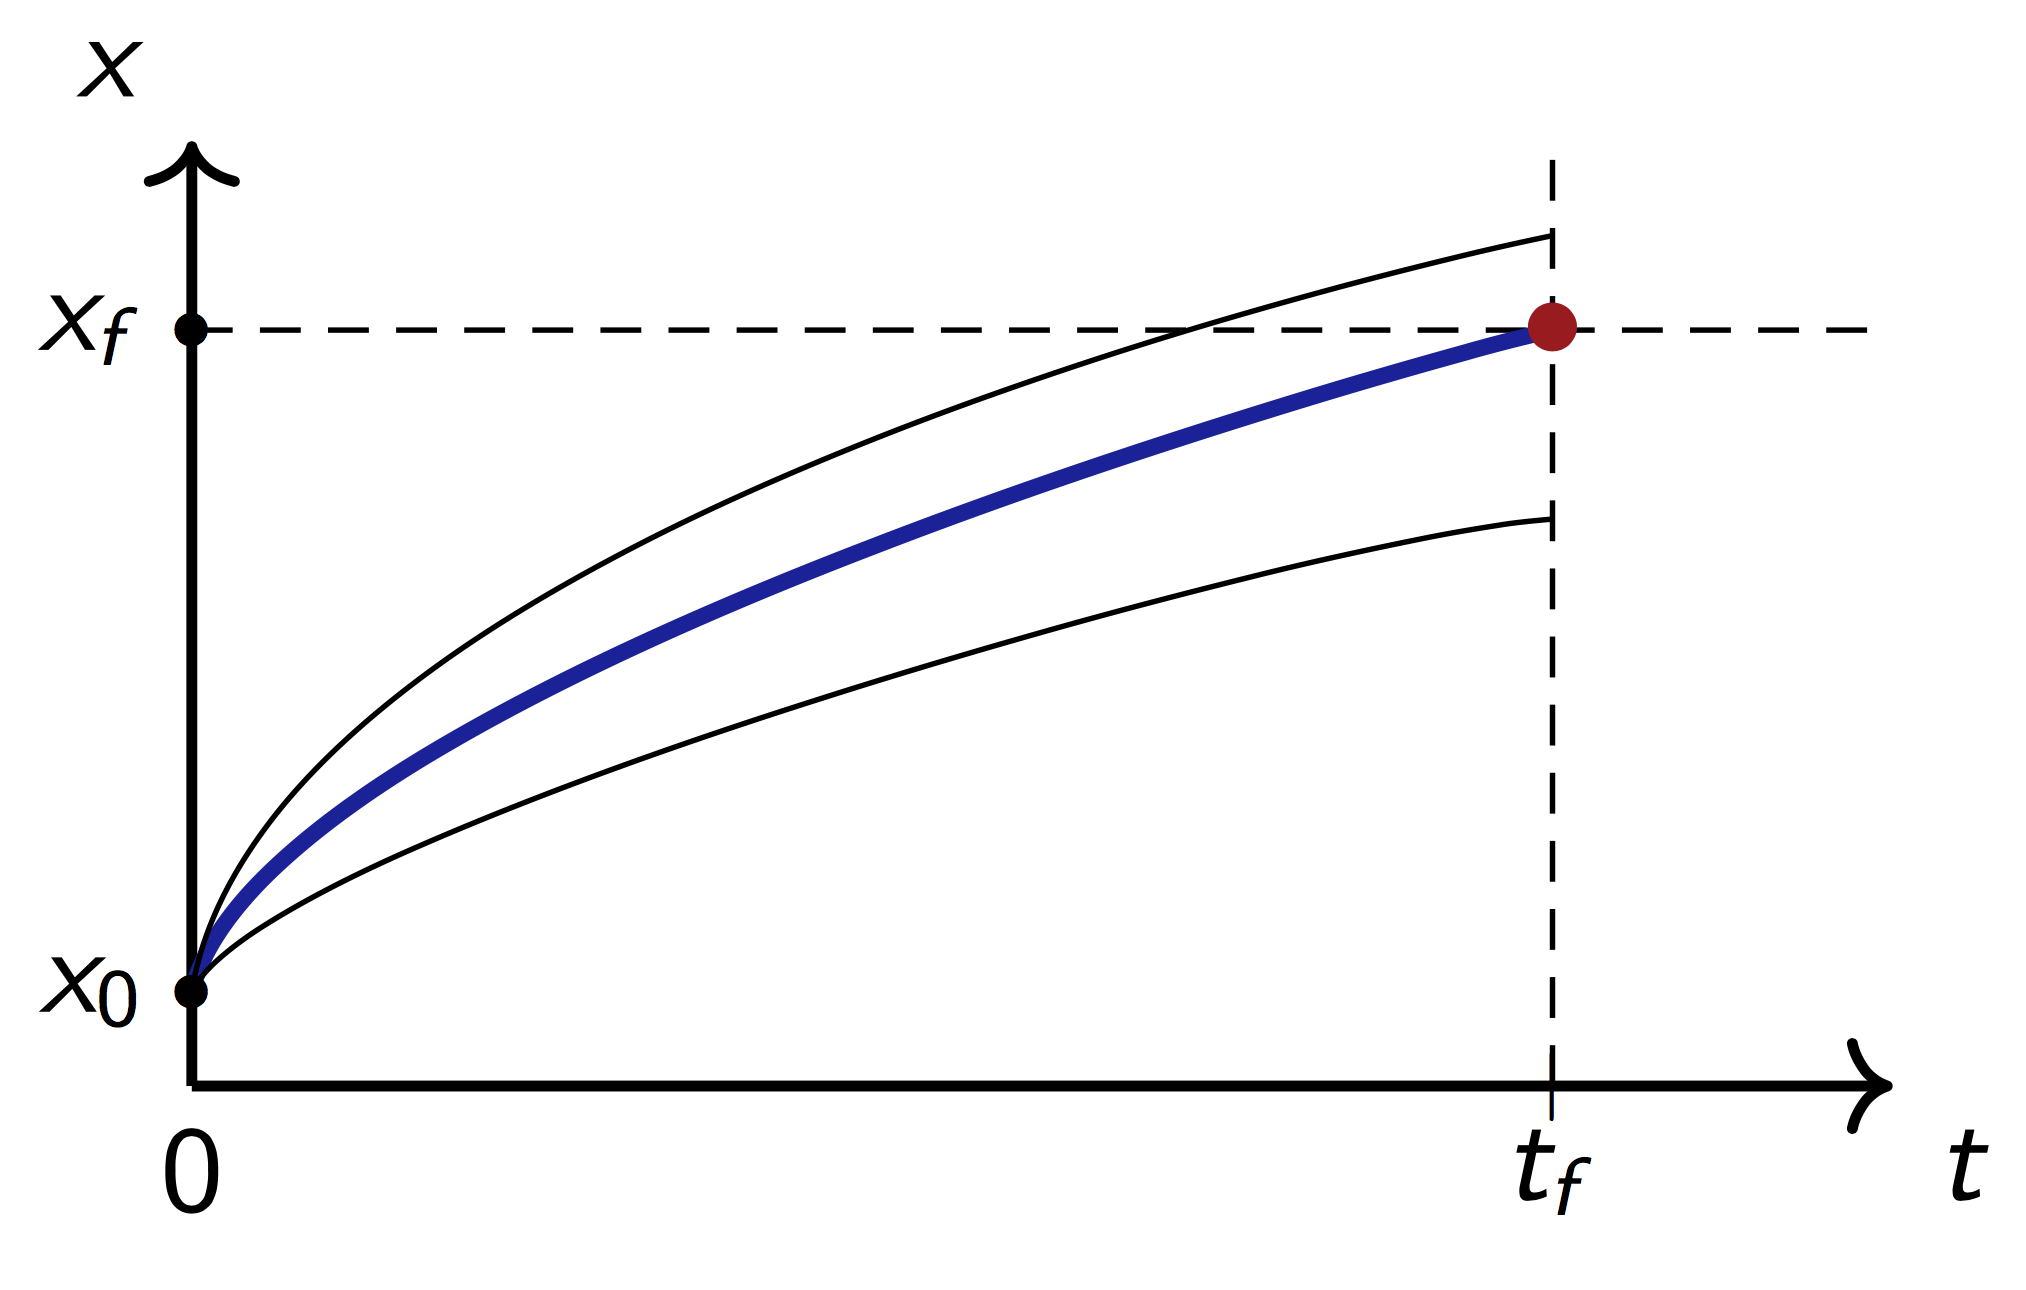
</div>
<div align="center">
<i>
Figure: Illustration of the shooting method in the state-time space. The blue trajectory reaches the target in red. The shooting method consists in finding the right impulse to reach the target.
</i>
</div>

<div align="center">
    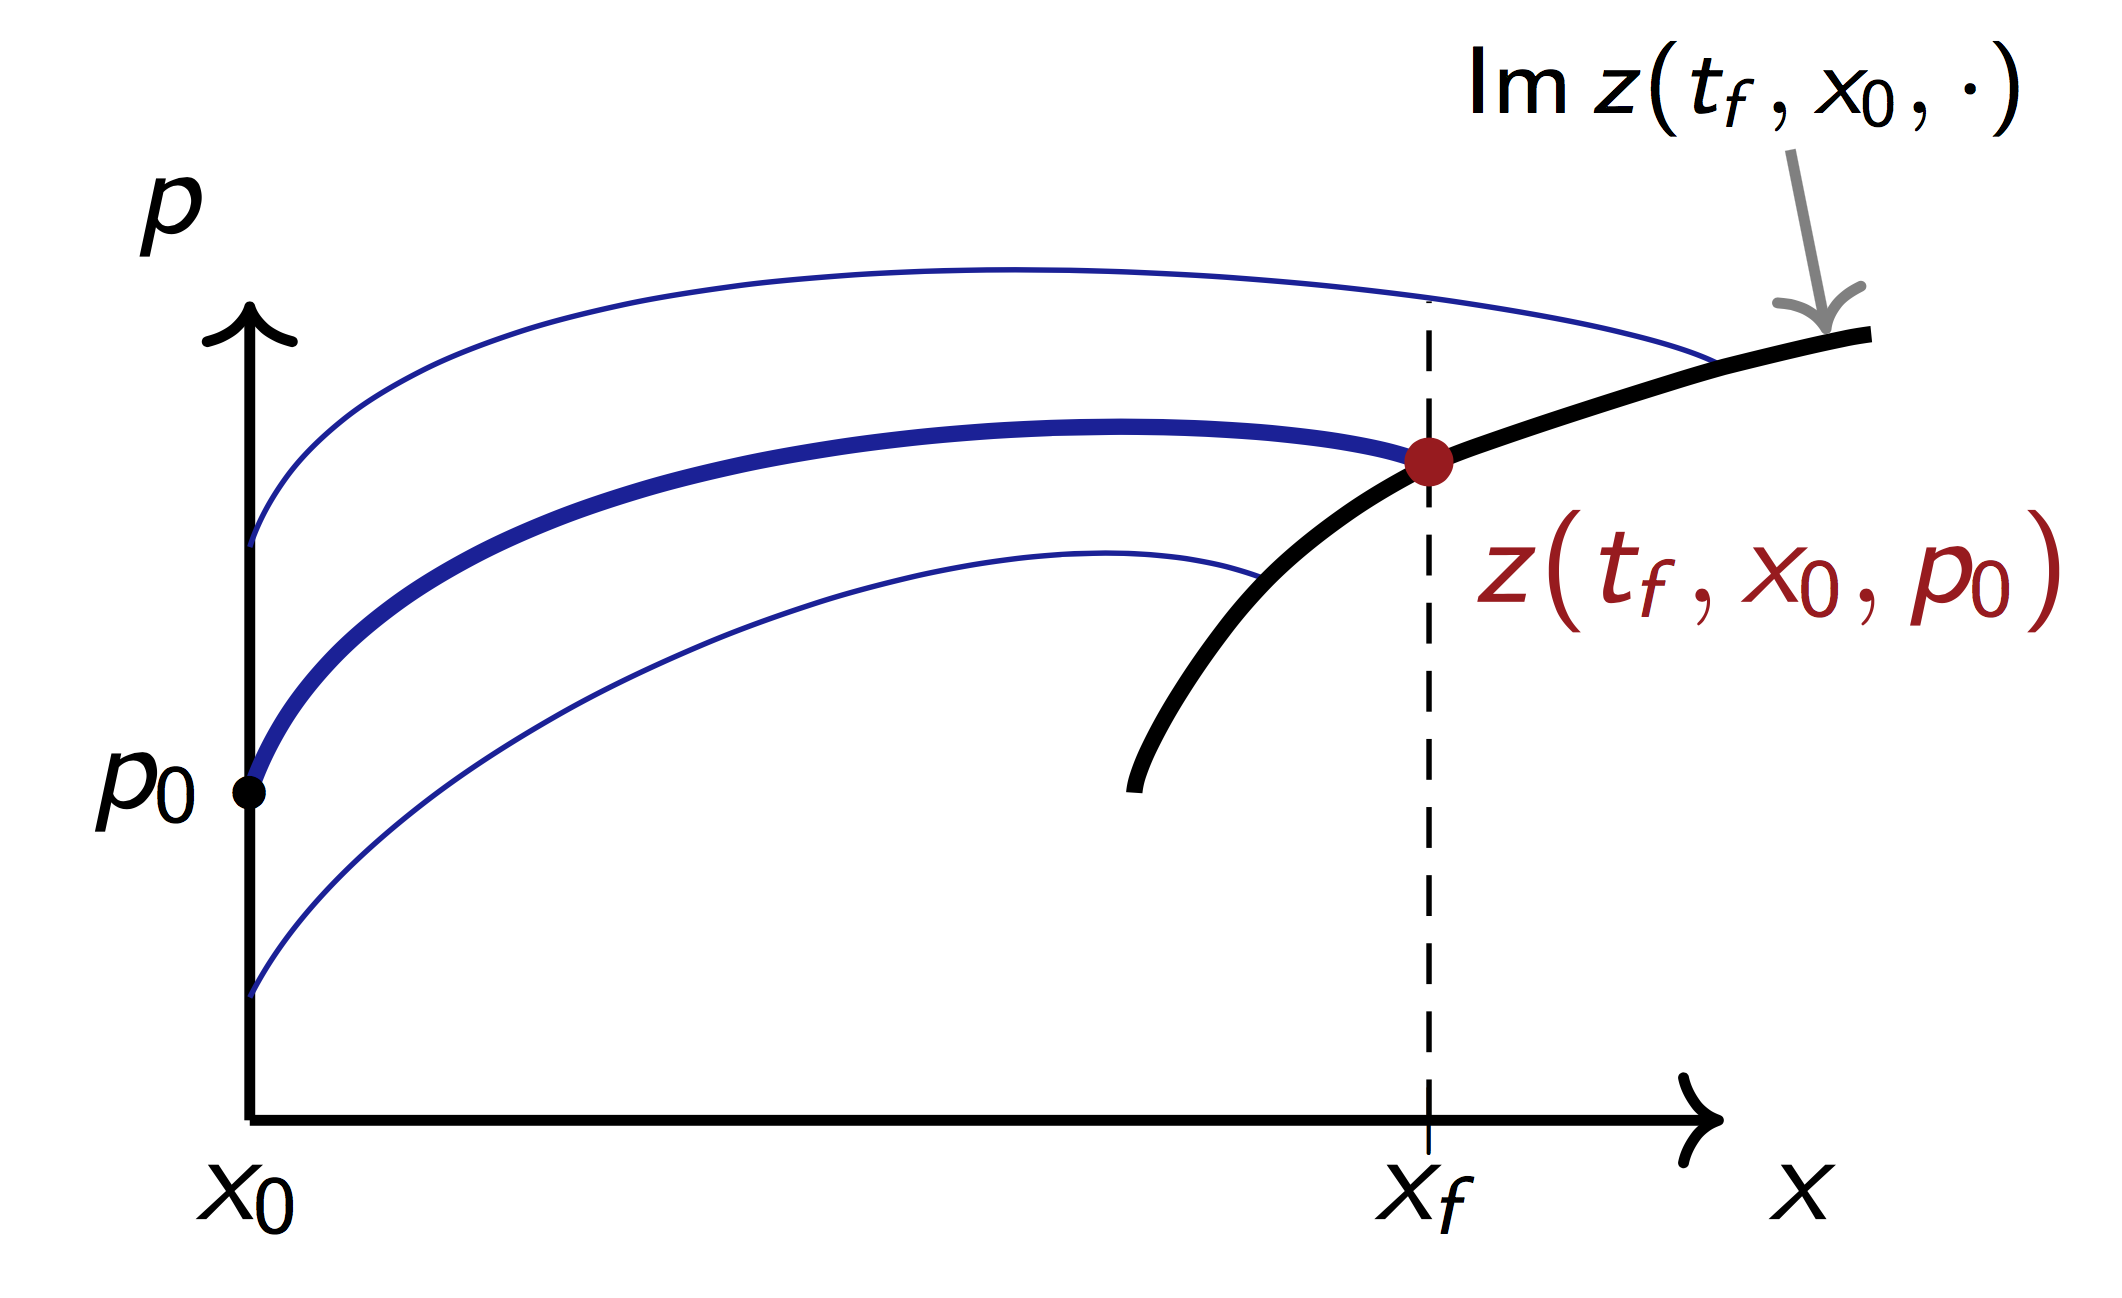
</div>
<div align="center">
<i>
Figure: Illustration of the shooting method in the cotangent space. The blue extremal reaches the target in red.
</i>
</div>


## IV) Numerical resolution of the shooting equations with the nutopy package

In [1]:
# import nutopy and numpy packages
import nutopy as nt
import nutopy.tools as tools
import nutopy.ocp as ocp
import numpy as np

### a) Simple 1D example

We recall the ocp:
$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{t_f} u^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) =  \displaystyle -x(t)+u(t), \quad  u(t) \in \mathrm{R}, \quad t \in [0, t_f] \text{ a.e.}, \\[1.0em]
        x(0) = x_0 , \quad x(t_f) = x_f,
    \end{array}
    \right. 
$$

with $t_f := 1$, $x_0 := -1$, $x_f := 0$ and $\forall\, t \in[0, t_f]$, $x(t) \in \mathrm{R}$.

The (maximized) Hamiltonian is

$$
    h(z) = H(z, u[z]) = -px + \frac{1}{2} p^2, \quad z = (x, p).
$$

and the Hamiltonian system is given by

$$
    \dot{x} = -x+p, \quad \dot{p} = p.
$$

The shooting function is

$$
    S(p_0) = \pi_x(z(t_f, x_0, p_0)) - x_f.
$$

The solution is $p_0^* \approx 0.313$.

#### Version 1: Using nutopy from the Hamiltonian system

In this first version, we choose to solve the shooting equations following the steps described in Section III)-a). In the next version, we will use the nutopy package in a more natural way.

We need the following methods: 
[nutopy.ivp.exp](https://ct.gitlabpages.inria.fr/nutopy/api/ivp/ivp-exp.html),
[nutopy.nle.solve](https://ct.gitlabpages.inria.fr/nutopy/api/nle/nle-solve.html).


In [2]:
# Definition of the Hamiltonian system
def hv(x, p):
    return np.array([-x + p, p])

# Definition of the exponential mapping
# The exp function computes the exponential of a system given in the first argument of the function
# The system has to be given in the form: f(t, z)
def exponential(t, hvfun, x0, p0):
    sol = nt.ivp.exp( lambda t, z: hvfun(z[0], z[1]), # we work with z=(x,p): f(t, z) = hvfun(x, p)
                      t,                              # final time
                      0.0,                            # initial time
                      np.array([x0, p0]) )            # z0 = (x0, p0)
    return sol.xf[0], sol.xf[1]                       # return z(t) = (x(t), p(t))

# Definition of the shooting equation
def shoot(p0):
    tf        =  1.0
    x0        = -1.0
    xf_target =  0.0
    xf, pf = exponential(tf, hv, x0, p0)
    return xf - xf_target  # x(tf, x0, p0) - xf_target

# The shooting method: resolution of the shooting equation
p0_guess = 1.0                             # initial guess for the Newton solver
sol      = nt.nle.solve(shoot, p0_guess);  # call to the Newton solver
p0_sol   = sol.x

print('NLE outputs: ', '\n\n p0_sol =', p0_sol, '\n shoot  =', shoot(p0_sol), '\n')
  


     Calls  |f(x)|                 |x|
 
         1  8.073217526767197e-01  1.000000000000000e+00
         2  1.428248003892962e-08  3.130352977215060e-01
         3  6.938893903907228e-18  3.130352855682848e-01
         4  6.938893903907228e-18  3.130352855682848e-01
         5  1.428248013607414e-08  3.130352734150637e-01
         6  6.938893903907228e-18  3.130352855682848e-01

 Results of the nle solver method:

 xsol    =  0.3130352855682848
 f(xsol) =  -6.938893903907228e-18
 nfev    =  6
 njev    =  2
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

NLE outputs:  

 p0_sol = 0.3130352855682848 
 shoot  = -6.938893903907228e-18 



#### Version 2: Using nutopy from the Hamiltonian

In this version we use nutopy in a more natural way. See this [page](https://ct.gitlabpages.inria.fr/gallery/smooth_case/smooth_case.html) for a more detailed example of the use of nutopy.

We need the following methods:
[nutopy.ocp](https://ct.gitlabpages.inria.fr/nutopy/api/ocp.html),
[nutopy.nle.solve](https://ct.gitlabpages.inria.fr/nutopy/api/nle/nle-solve.html).


In [3]:
# Definition of the maximized Hamiltonian and its derivatives
# The derivatives may be computed by hand as here or by Automatic Differentiation for instance

def dhfun(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    hd = -p*dx + (-x+p)*dp
    return hd
    
def d2hfun(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd = -d2p*dx + (-d2x+d2p)*dp
    return hdd

@tools.tensorize(dhfun, d2hfun, tvars=(2, 3))
def hfun(t, x, p):
    h =  p * (-x + p) - 0.5*p**2
    return h

h = ocp.Hamiltonian(hfun)   # The Hamiltonian object

f = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                            # the exponential mapping with its derivative
                            # that can be used to define the Jacobian of the 
                            # shooting function

# Definition of the shooting function
def shoot(p0):
    t0        = 0.0
    tf        = 1.0
    x0        = np.array([-1.0])
    xf_target = np.array([ 0.0])
    xf, pf = f(t0, x0, p0, tf)  # We use the flow to get z(tf, x0, p0)
    s = xf - xf_target  # x(tf, x0, p0) - xf_target
    return s

# The shooting method: resolution of the shooting equation
p0_guess = np.array([1.0])
sol      = nt.nle.solve(shoot, p0_guess);
p0_sol   = sol.x

print('NLE\t: ', '\n\n p0_sol =', p0_sol, '\n shoot  =', shoot(p0_sol), '\n')  


     Calls  |f(x)|                 |x|
 
         1  8.073217526767197e-01  1.000000000000000e+00
         2  1.428248003892962e-08  3.130352977215060e-01
         3  6.938893903907228e-18  3.130352855682848e-01
         4  6.938893903907228e-18  3.130352855682848e-01
         5  1.428248013607414e-08  3.130352734150637e-01
         6  6.938893903907228e-18  3.130352855682848e-01

 Results of the nle solver method:

 xsol    =  [0.31303529]
 f(xsol) =  [-6.9388939e-18]
 nfev    =  6
 njev    =  2
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

NLE	:  

 p0_sol = [0.31303529] 
 shoot  = [-6.9388939e-18] 



In [4]:
# We define the derivative of the shooting function and use it for the resolution of S=0. 
# Previously, the Jacobian was computed by finite differences.
# We do not provide S'(p0) but S'(p0).dp0. 
# In our scalar case, it is quite similar but in general, it simpler to provide S'(p0).dp0.

def dshoot(p0, dp0):
    t0        = 0.0
    tf        = 1.0
    x0        = np.array([-1.0])
    (xf, dxf), _ = f(t0, x0, (p0, dp0), tf)
    ds = dxf
    return ds

shoot   = nt.tools.tensorize(dshoot)(shoot) # the use of tensorize permits to code S'(p0).dp0 instead of S'(p0)

# The shooting method: resolution of the shooting equation
p0_guess = np.array([1.0])
sol      = nt.nle.solve(shoot, p0_guess, df=shoot);
p0_sol   = sol.x

print('NLE\t: ', '\n\n p0_sol =', p0_sol, '\n shoot  =', shoot(p0_sol), '\n')  


     Calls  |f(x)|                 |x|
 
         1  8.073217526767197e-01  1.000000000000000e+00
         2  3.184008612322486e-11  3.130352855411916e-01
         3  1.110223024625157e-16  3.130352855682850e-01

 Results of the nle solver method:

 xsol    =  [0.31303529]
 f(xsol) =  [1.11022302e-16]
 nfev    =  3
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

NLE	:  

 p0_sol = [0.31303529] 
 shoot  = [1.11022302e-16] 



### b) Calculus of variations

**_Problem 1:_**

Les us consider the following problem which consists in computing the Euclidean distance between two points of the plan:
$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{t_f} ||u(t)||^2 \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) =  \displaystyle u(t), \quad  u(t) \in \mathrm{R}^2, \quad t \in [0, t_f] \text{ a.e.}, \\[1.0em]
        x(0) = A , \quad x(t_f) = B,
    \end{array}
    \right. 
$$

with $t_f > 0$ fixed and $A, B \in \mathrm{R}^2$ given.

The (maximized) Hamiltonian is

$$
    h(z) = H(z, u[z]) = \frac{1}{2} ||p||^2, \quad z = (x, p).
$$

and the Hamiltonian system is given by

$$
    \dot{x} = p, \quad \dot{p} = 0.
$$

The shooting function is

$$
    S(p_0) = \pi_x(z(t_f, A, p_0)) - B.
$$

In [5]:
# Definition of the maximized Hamiltonian and its derivatives

def dhfun(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    hd = np.dot(p, dp)
    return hd
    
def d2hfun(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd = np.dot(d2p, dp)
    return hdd

@tools.tensorize(dhfun, d2hfun, tvars=(2, 3))
def hfun(t, x, p):
    h =  0.5*np.dot(p, p)
    return h

h = ocp.Hamiltonian(hfun)   # The Hamiltonian object

f = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                            # the exponential mapping with its derivative
                            # that can be used to define the Jacobian of the 
                            # shooting function

# Definition of the shooting function and its derivative
# the use of tensorize permits to code S'(p0).dp0 instead of S'(p0)
def dshoot(p0, dp0):
    t0 = 0.0
    tf = 1.0
    A  = np.array([ 0.0, 0.0])
    (xf, dxf), _ = f(t0, A, (p0, dp0), tf)
    ds = dxf
    return ds

@tools.tensorize(dshoot)
def shoot(p0):
    t0     = 0.0
    tf     = 1.0
    A      = np.array([ 0.0, 0.0])
    B      = np.array([ 1.0, 1.0])
    xf, pf = f(t0, A, p0, tf)  # We use the flow to get z(tf, x0, p0)
    s = xf - B                  # x(tf, x0, p0) - B
    return s

# The shooting method: resolution of the shooting equation
p0_guess = np.array([0.1, 0.1])
sol      = nt.nle.solve(shoot, p0_guess, df=shoot);
p0_sol   = sol.x

print('NLE\t: ', '\n\n p0_sol =', p0_sol, '\n shoot  =', shoot(p0_sol), '\n')  


     Calls  |f(x)|                 |x|
 
         1  1.272792206135785e+00  1.414213562373095e-01
         2  3.140184917367550e-16  1.414213562373095e+00
         3  3.140184917367550e-16  1.414213562373095e+00
         4  3.140184917367550e-16  1.414213562373095e+00
         5  3.140184917367550e-16  1.414213562373095e+00
         6  3.140184917367550e-16  1.414213562373095e+00
         7  3.140184917367550e-16  1.414213562373095e+00
         8  7.954951288348694e-02  1.493763075256582e+00
         9  3.140184917367550e-16  1.414213562373095e+00
        10  3.140184917367550e-16  1.414213562373095e+00
        11  3.140184917367550e-16  1.414213562373095e+00
        12  3.140184917367550e-16  1.414213562373095e+00
        13  3.140184917367550e-16  1.414213562373095e+00
        14  3.140184917367550e-16  1.414213562373095e+00
        15  3.140184917367550e-16  1.414213562373095e+00
        16  3.140184917367550e-16  1.414213562373095e+00
        17  3.140184917367550e-16  1.414213562

**_Problem 2:_**

Les us consider the following problem which consists in computing the Euclidean distance between a point and a line of the plan:
$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{t_f} ||u(t)||^2 \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) =  \displaystyle u(t), \quad  u(t) \in \mathrm{R}^2, \quad t \in [0, t_f] \text{ a.e.}, \\[1.0em]
        x(0) = A , \quad x_1(t_f) = 1,
    \end{array}
    \right. 
$$

with $t_f > 0$ fixed and $A\in \mathrm{R}^2$ given.

The (maximized) Hamiltonian and the Hamiltonian system are similar to Problem 1. We have the transversality condition

$$
    p(t_f) = (\lambda, 0).
$$

In this case, the shooting function is given by

$$
    S(p_0, \lambda) = \left( (x_1(t_f, A, p_0) - 1, p_1(t_f, A, p_0) - \lambda, p_2(t_f, A, p_0) \right).
$$

In [6]:
# Definition of the maximized Hamiltonian and its derivatives

def dhfun(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    hd = np.dot(p, dp)
    return hd
    
def d2hfun(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd = np.dot(d2p, dp)
    return hdd

@tools.tensorize(dhfun, d2hfun, tvars=(2, 3))
def hfun(t, x, p):
    h =  0.5*(p[0]**2+p[1]**2)
    return h

h = ocp.Hamiltonian(hfun)   # The Hamiltonian object

f = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                            # the exponential mapping with its derivative
                            # that can be used to define the Jacobian of the 
                            # shooting function

# Definition of the shooting function and its derivative
# the use of tensorize permits to code S'(p0).dp0 instead of S'(p0)
def dshoot(y, dy):
    p0  = y[0:2]
    l   = y[2]
    dp0 = dy[0:2]
    dl  = dy[2]
    t0  = 0.0
    tf  = 1.0
    A   = np.array([ 0.0, 0.0])
    (xf, dxf), (pf, dpf) = f(t0, A, (p0, dp0), tf)
    ds    = np.zeros([3])
    ds[0] = dxf[0]
    ds[1] = dpf[0]
    ds[2] = dpf[1]
    return ds

@tools.tensorize(dshoot)
def shoot(y):
    p0     = y[0:2]
    l      = y[2]
    t0     = 0.0
    tf     = 1.0
    A      = np.array([ 0.0, 0.0])
    xf, pf = f(t0, A, p0, tf)
    s      = np.zeros([3])
    s[0]   = xf[0] - 1.0
    s[1]   = pf[0] - l
    s[2]   = pf[1]
    return s

# The shooting method: resolution of the shooting equation
y_guess  = np.array([0.1, 0.1, 0.5])
sol      = nt.nle.solve(shoot, y_guess, df=shoot);
y_sol    = sol.x

print('NLE\t: ', '\n\n p0_sol =', y_sol[0:2], '\n lambda =', y_sol[2], '\n', '\n shoot  =', shoot(y_sol), '\n')  


     Calls  |f(x)|                 |x|
 
         1  9.899494936611666e-01  5.196152422706632e-01
         2  5.265754007445733e+01  5.341221252310977e+01
         3  2.215058419779381e-02  1.398638437904777e+00
         4  1.337306002566763e-04  1.414308127348630e+00
         5  2.220446049250333e-16  1.414213562373095e+00
         6  2.220446049250313e-16  1.414213562373095e+00
         7  2.220446049250313e-16  1.414213562373095e+00
         8  6.686530012833813e-05  1.414260844070578e+00
         9  2.220446049250313e-16  1.414213562373095e+00
        10  3.140184917367550e-16  1.414213562373095e+00
        11  3.140184917367550e-16  1.414213562373095e+00
        12  3.140184917367550e-16  1.414213562373095e+00
        13  3.140184917367550e-16  1.414213562373095e+00
        14  3.140184917367550e-16  1.414213562373095e+00
        15  3.140184917367550e-16  1.414213562373095e+00
        16  3.140184917367550e-16  1.414213562373095e+00
        17  3.140184917367550e-16  1.414213562

### c) An energy min navigation problem - exercice

Les us consider the following problem in the plan:
$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{t_f} ||u(t)||^2 \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) =  \displaystyle (1, 0) + u(t), \quad  u(t) \in \mathrm{R}^2, \quad t \in [0, t_f] \text{ a.e.}, \\[1.0em]
        x(0) = A , \quad x_2(t_f) = 1,
    \end{array}
    \right. 
$$

with $t_f = 1$ fixed and $A = (0,0) \in \mathrm{R}^2$ given.

<div class="alert alert-info">

**_Question 1:_**
    
Write the maximized Hamiltonian, the Hamiltonian system and the transversality condition given by the PMP.
    
</div>

**Answer 1:** To complete here (double-click on the line to complete)

<div class="alert alert-info">

**_Question 2:_**
    
Write the shooting function $S(p_0, \lambda)$, $p_0 \in \mathrm{R}^2$, $\lambda \in \mathrm{R}$.
    
</div>

**Answer 2:** To complete here (double-click on the line to complete)

<div class="alert alert-info">

**_Question 3:_**
    
Complete/Modify the following code to find the solution of the shooting equations.
    
</div>

In [7]:
# Definition of the maximized Hamiltonian and its derivatives

def dhfun(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    hd = 0.0 ### TO COMPLETE
    return hd
    
def d2hfun(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd = 0.0 ### TO COMPLETE
    return hdd

@tools.tensorize(dhfun, d2hfun, tvars=(2, 3))
def hfun(t, x, p):
    h =  0.0 ### TO COMPLETE
    return h

h = ocp.Hamiltonian(hfun)   # The Hamiltonian object

f = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                            # the exponential mapping with its derivative
                            # that can be used to define the Jacobian of the 
                            # shooting function

# Definition of the shooting function and its derivative
# the use of tensorize permits to code S'(p0).dp0 instead of S'(p0)
def dshoot(y, dy):  ### TO COMPLETE
    ds    = np.zeros([3])
    return ds

@tools.tensorize(dshoot) ### TO COMPLETE
def shoot(y):
    s      = np.zeros([3])
    return s

# The shooting method: resolution of the shooting equation
y_guess  = np.array([0.1, 0.1, 0.5])
sol      = nt.nle.solve(shoot, y_guess, df=shoot);
y_sol    = sol.x

print('NLE\t: ', '\n\n p0_sol =', y_sol[0:2], '\n lambda =', y_sol[2], '\n', '\n shoot  =', shoot(y_sol), '\n')  


     Calls  |f(x)|                 |x|
 
         1  0.000000000000000e+00  5.196152422706632e-01
         2  0.000000000000000e+00  5.196152422706632e-01

 Results of the nle solver method:

 xsol    =  [0.1 0.1 0.5]
 f(xsol) =  [0. 0. 0.]
 nfev    =  2
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

NLE	:  

 p0_sol = [0.1 0.1] 
 lambda = 0.5 
 
 shoot  = [0. 0. 0.] 

